## Quantile Random Forest with 5 CV

In [2]:
# import the necessary libraries 
import import_ipynb
from iv_test_train_split import *
from v_utils import *

from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from quantile_forest import RandomForestQuantileRegressor
from sklearn import metrics

import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")


ModuleNotFoundError: ignored

In [ ]:
seed = 447

param_grid = { "n_estimators"  : [100, 150, 200, 225, 250],
           "criterion"         : ['friedman_mse', 'squared_error'],
           "max_features"      : ['auto'],
           "max_depth"         :[3, 4, 5, 6, 7, 10],
           "bootstrap": [True]}

rf = RandomForestQuantileRegressor(random_state=seed)

rf_model = GridSearchCV(rf, param_grid, cv=5)
rf_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestQuantileRegressor(random_state=447),
             param_grid={'bootstrap': [True],
                         'criterion': ['friedman_mse', 'squared_error'],
                         'max_depth': [3, 4, 5, 6, 7, 10],
                         'max_features': ['auto'],
                         'n_estimators': [100, 150, 200, 225, 250]})

In [ ]:
# Print the best hyperparameters and the best score
print("Best hyperparameters: ", rf_model.best_params_)

Best hyperparameters:  {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 200}


In [ ]:
"""
 @input:
 - X_train (numpy array or pandas DataFrame): Training data with features.
 - y_train (numpy array or pandas Series): Training data with target variable.
 - alpha (float): Quantile level for loss function.
 
 @output: Trained RF model with the specified best hyperparameters 

"""
def train_rf_model(X_train, y_train, fold_index=None, n_folds=None):
    model = RandomForestQuantileRegressor(
        random_state = 447,
        n_estimators = 200,
        criterion=['squared_error'],
        max_features = ['auto'],
        max_depth = 10,
        bootstrap= True,
    )
    model.fit(X_train, y_train)
    return model

In [ ]:
n_estimators = 200
max_depth = 10
max_features = 'auto'
criterion = 'squared_error'
rf_model = RandomForestQuantileRegressor(random_state=447, n_estimators=n_estimators, criterion = criterion, max_depth=max_depth, max_features=max_features, oob_score=True)
rf_model.fit(X_train, y_train)


RandomForestQuantileRegressor(max_depth=10, max_features='auto',
                              n_estimators=200, oob_score=True,
                              random_state=447)

In [ ]:
# Make point estimate and bound predictions for both quantile levels
y_pred = rf_model.predict(X_test, quantiles=[0.5, 0.25, 0.75, 0.1, 0.9])

point_estimate = y_pred[:, 0]
lower_bound50 = y_pred[:, 1]
upper_bound50 = y_pred[:, 2]
lower_bound80 = y_pred[:, 3]
upper_bound80 = y_pred[:, 4]

# Concatenate actual target values and predictions for both quantile levels into dataframes
# convert point estimate, lower bound, upper bound back so it is not in log form
predictions50 = pd.concat([
    np.exp(y_test).reset_index(drop=True),
    pd.Series( np.exp(point_estimate), name='point_estimate'),
    pd.Series(np.exp(lower_bound50), name='lower_bound'),
    pd.Series( np.exp(upper_bound50), name='upper_bound')
], axis=1).round(3)

predictions80 = pd.concat([
    np.exp(y_test).reset_index(drop=True),
    pd.Series(np.exp(point_estimate), name='point_estimate'),
    pd.Series(np.exp(lower_bound80), name='lower_bound'),
    pd.Series(np.exp(upper_bound80), name='upper_bound')
], axis=1).round(3)

# print prediction LB and UP for level = 50%
predictions50.head()

# Print prediction LB and UP for level = 50%
predictions50.head()

,price,point_estimate,lower_bound,upper_bound
0,80.0,93.499,70.0,149.000
1,195.0,140.996,100.0,194.000
2,100.0,107.000,90.0,140.000
3,40.0,51.000,44.0,62.249
4,260.0,169.499,143.0,221.498


In [ ]:
predictions80.head()

,price,point_estimate,lower_bound,upper_bound
0,80.0,93.499,50.0,360.0
1,195.0,140.996,90.0,200.0
2,100.0,107.000,80.0,188.0
3,40.0,51.000,37.0,76.0
4,260.0,169.499,114.9,298.1


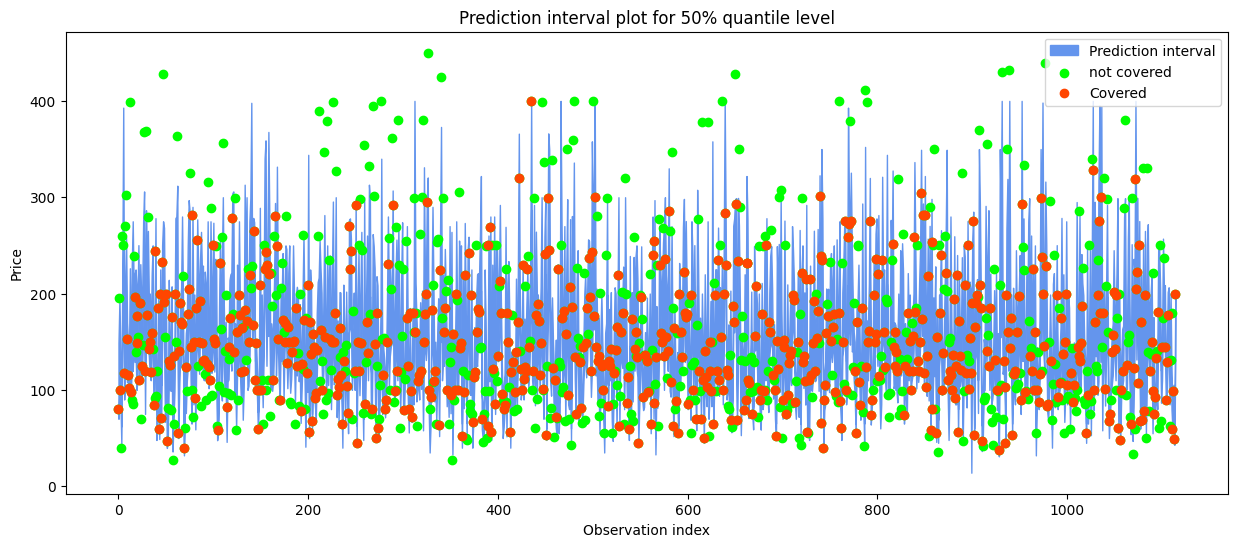

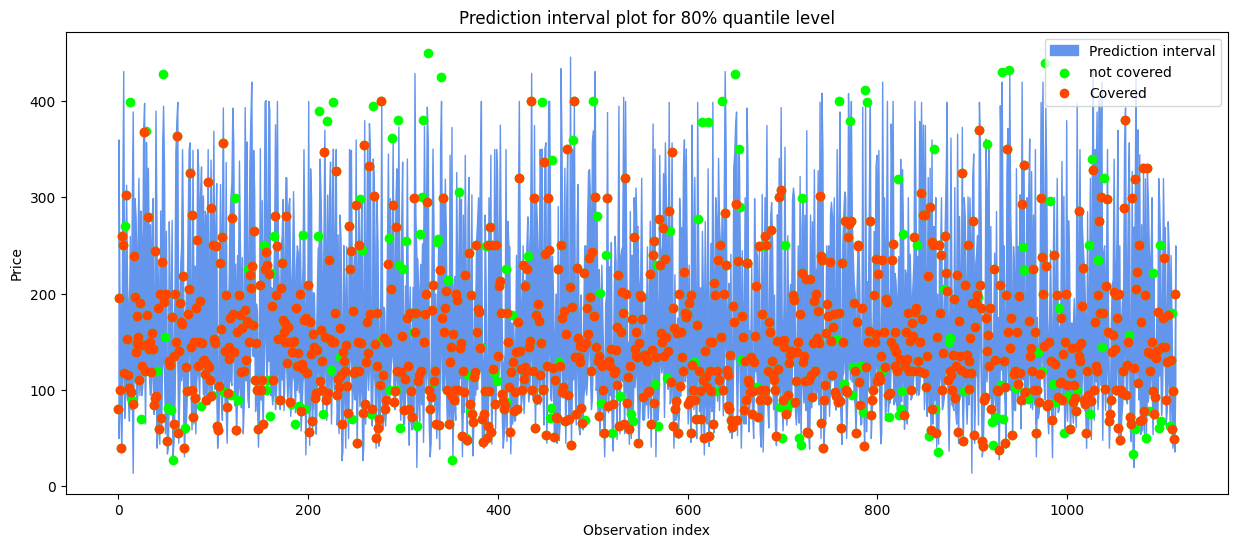

In [ ]:
# actual vs predicted using prediction interval
plot_prediction_interval(y_test, lower_bound50, upper_bound50, 50)
plot_prediction_interval(y_test, lower_bound80, upper_bound80, 80)

In [ ]:
def cross_validate_metrics_rf(X, y, k=5, alpha_levels=[0.5, 0.8]):
    kf = KFold(n_splits=k, shuffle=True, random_state=447)
    
    metrics_results = []
    fold_num = 1
    
    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train model
        rf_model = RandomForestQuantileRegressor(random_state=seed, oob_score=True)
        rf_model.fit(X_train, y_train)

        # Make point estimate
        point_estimate = rf_model.predict(X_test)
        
        # Make lower and upper bound predictions for each alpha level
        bounds = {}
        for alpha in alpha_levels:
            bounds[alpha] = rf_model.predict(X_test, quantiles=[(1 - alpha) / 2, (1 + alpha) / 2])

        # Calculate metrics
        aic = AIC_rf(rf_model, X_train, y_train)
        mse = metrics.mean_squared_error(y_test, point_estimate)
        rmse = np.sqrt(mse)
        
        interval_metrics = {}
        for alpha in alpha_levels:
            pred_obj = np.column_stack((point_estimate, bounds[alpha][:, 0], bounds[alpha][:, 1]))
            interval_result = interval_score(pred_obj, y_test.values, alpha)
            
            interval_metrics[alpha] = {
                'AIC': aic,
                f'Interval Average Length ({alpha})': interval_result['summary'][1],
                f'Interval Score ({alpha})': interval_result['summary'][2],
                f'Coverage Rate ({alpha})': interval_result['summary'][3]
            }
        
        metrics_results.append({
            'Fold': fold_num,
            'AIC': aic,
            'MSE': mse,
            'RMSE': rmse,
            **{f"{key}": value for alpha, metrics_dict in interval_metrics.items() for key, value in metrics_dict.items()}
        })
        
        fold_num += 1
    
    # Create a DataFrame with the results
    results_df = pd.DataFrame(metrics_results)
    
    # Calculate average values and append them to the DataFrame
    avg_metrics = {
        'Fold': 'Average',
        'AIC': results_df['AIC'].mean(),
        'MSE': results_df['MSE'].mean(),
        'RMSE': results_df['RMSE'].mean(),
        **{key: results_df[key].mean() for key in results_df.columns if 'Interval' in key or 'Coverage' in key}
    }
    
    results_df = results_df.append(avg_metrics, ignore_index=True)
    
    # Round the values to 3 decimals
    results_df = results_df.round(3)
    
    # Set the DataFrame index to the 'Fold' column
    results_df.set_index('Fold', inplace=True)
    
    return results_df

In [ ]:
results_rf_df = cross_validate_metrics_rf(X, y_log)

In [ ]:
display(results_rf_df)

,AIC,MSE,RMSE,Interval Average Length (0.5),Interval Score (0.5),Coverage Rate (0.5),Interval Average Length (0.8),Interval Score (0.8),Coverage Rate (0.8)
Fold,,,,,,,,,
1,1077014.941,0.104,0.322,0.419,0.785,0.534,0.803,1.149,0.802
2,1076215.300,0.130,0.361,0.415,0.854,0.516,0.796,1.195,0.787
3,1076551.971,0.112,0.334,0.408,0.789,0.550,0.784,1.133,0.794
4,1074682.657,0.112,0.335,0.415,0.819,0.486,0.797,1.177,0.773
5,1078565.616,0.107,0.327,0.407,0.785,0.518,0.791,1.119,0.799
Average,1076606.097,0.113,0.336,0.413,0.806,0.521,0.794,1.155,0.791


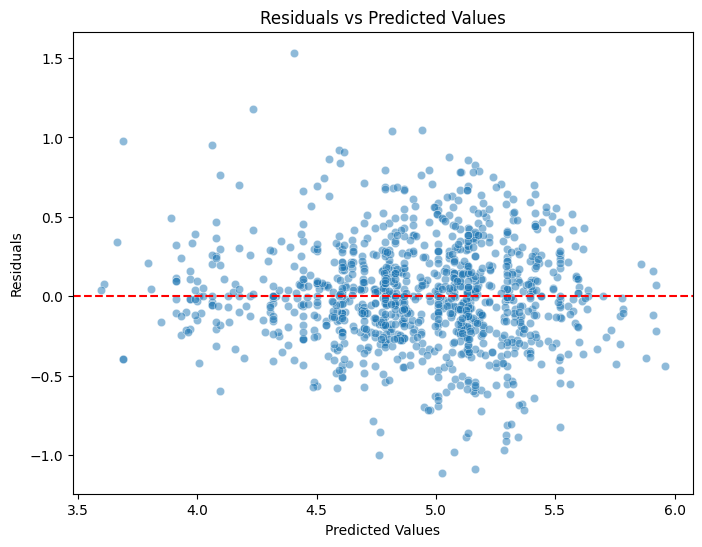

In [ ]:
# put in appendix
# residual plot
rf_model.predict(X_test)
# Residual plot
plt.figure(figsize=(8, 6))
residuals = y_test - point_estimate
sns.scatterplot(x= point_estimate, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

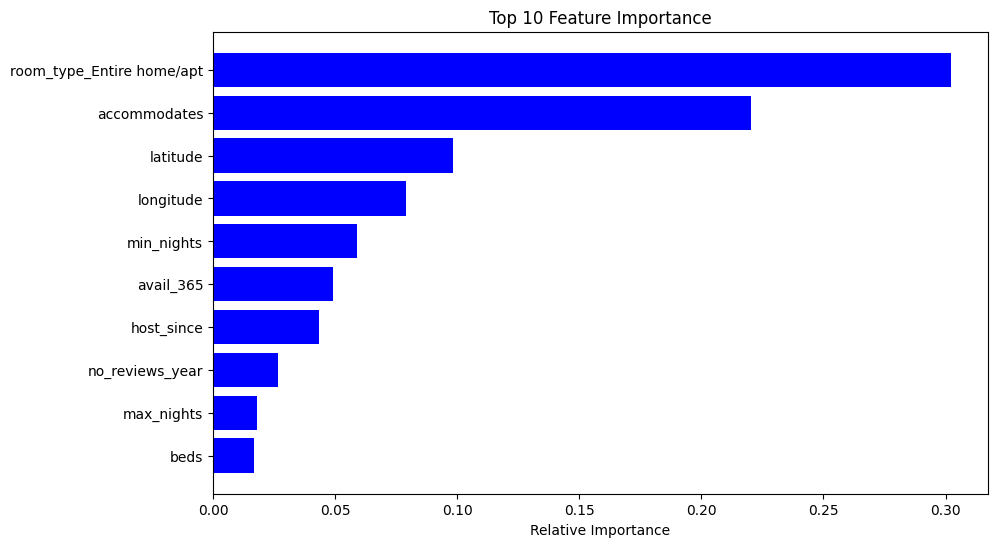

In [ ]:
plt.figure(figsize=(10, 6))
importance = rf_model.feature_importances_
indices = np.argsort(importance)[-10:]  # Select the indices of top 10 features
feature_names = X.columns

plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Top 10 Feature Importance')
plt.show()

In [ ]:
# Extract the interval score columns from the DataFrame
interval_scores_df = results_rf_df[['Interval Score (0.5)', 'Interval Score (0.8)']]

# Apply the exponential function to convert back log transform on interval score
interval_scores_exp_rf = interval_scores_df.applymap(exp_func)
interval_scores_exp_rf = interval_scores_exp_rf.round(3)

In [ ]:
interval_scores_exp_rf.head(6)

,Interval Score (0.5),Interval Score (0.8)
Fold,,
1,2.192,3.155
2,2.349,3.304
3,2.201,3.105
4,2.268,3.245
5,2.192,3.062
Average,2.239,3.174
